In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from wordcloud import WordCloud
import statsmodels.api as sm

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')

## Load the houseprices data from Thinkful's database.

In [54]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

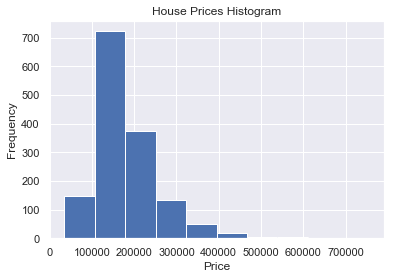

In [55]:
#view the target variable as a histogram

plt.hist(house_prices_df.saleprice)
plt.title("House Prices Histogram")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

The histogram of House Prices is not normally distributed, but instead is skewed right.

In [24]:
#examine the data frame

print(
    house_prices_df.head(),
    house_prices_df.info(),
    house_prices_df.describe()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [22]:
#determine which variables have missing values and in what percentage

missing_values_ratios = (house_prices_df.isnull().sum()/house_prices_df.isnull().count())
missing_values_ratios.sort_values(ascending=False).head(30)

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagecond      0.055479
garagetype      0.055479
garageyrblt     0.055479
garagefinish    0.055479
garagequal      0.055479
bsmtexposure    0.026027
bsmtfintype2    0.026027
bsmtfintype1    0.025342
bsmtcond        0.025342
bsmtqual        0.025342
masvnrarea      0.005479
masvnrtype      0.005479
electrical      0.000685
utilities       0.000000
yearremodadd    0.000000
mssubclass      0.000000
foundation      0.000000
extercond       0.000000
exterqual       0.000000
exterior2nd     0.000000
exterior1st     0.000000
roofmatl        0.000000
roofstyle       0.000000
yearbuilt       0.000000
dtype: float64

It appears that most of the columns are not missing data, so we will avoid using the ones that are.

In [62]:
#check the correlation of the numerical variables with the target
np.abs(house_prices_df[house_prices_df.select_dtypes(['int64', 'float64']).columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False).head(20)

saleprice       1.000000
overallqual     0.790982
grlivarea       0.708624
garagecars      0.640409
garagearea      0.623431
totalbsmtsf     0.613581
firstflrsf      0.605852
fullbath        0.560664
totrmsabvgrd    0.533723
yearbuilt       0.522897
yearremodadd    0.507101
garageyrblt     0.486362
masvnrarea      0.477493
fireplaces      0.466929
bsmtfinsf1      0.386420
lotfrontage     0.351799
wooddecksf      0.324413
secondflrsf     0.319334
openporchsf     0.315856
halfbath        0.284108
Name: saleprice, dtype: float64

In [63]:
#here we add an interaction variable
house_prices_df['year_by_year'] = house_prices_df.yearbuilt * house_prices_df.yearremodadd

#X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'year_by_year']]

#Y is the target
Y = house_prices_df.saleprice

## Split your data into train and test sets.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


## Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.

In [70]:
# Adding a constant to the model
X_train = sm.add_constant(X_train)

# Fitting an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     912.9
Date:                Wed, 24 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:23:08   Log-Likelihood:                -13996.
No. Observations:                1168   AIC:                         2.800e+04
Df Residuals:                    1163   BIC:                         2.803e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.889e+04   5215.655    -18.961      0.000   -1.09e+05   -8.87e+04
overallqual  2.441e+04   1219.646     20.015      0.000     2.2e+04    2.68e+04
grlivarea      43.2118      2.757     15.672      0.000      37.802      48.622
garagecars   1.989e+04   1971.236     10.091      0.000     1.6e+04    2.38e+04
totalbsmtsf    28.3480      3.072      9.229      0.000      22.322      34.375
==============================================================================
Omnibus:                      371.463   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27217.221
Skew:                          -0.531   Prob(JB):                         0.00
Kurtosis:                      26.625   Cond. No.                     9.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model has a F-stat probability of zero, and the adjusted R-squared value is 0.758.  Not a perfect model, but not a terrible one either.

## Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.

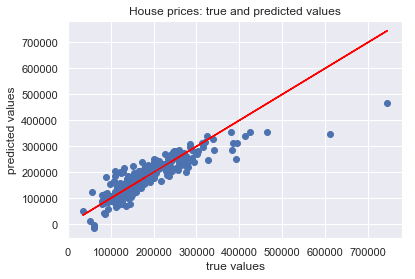

Mean absolute error of the prediction is: 26089.46787364969
Mean squared error of the prediction is: 1574193490.0111256
Root mean squared error of the prediction is: 39676.10729407719
Mean absolute percentage error of the prediction is: 16.18868600344772


In [74]:
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true and predicted values")
plt.show()


print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The model looks pretty good based on the predictions from the test set.  It doesn't perform as well on the higher values of the target. Based on the information provided in the module, these metrics are most useful when they are being compared, so I'm not sure what to say about them.  MAE, MSE, and RMSE seem high based on the very limited number of examples the module has provided.  Conversely, MAPE seems low.

## Is the performance of your model satisfactory? Why?

It appears to be doing a decent job based on the above scatter plot.

## Try to improve your model in terms of predictive performance by adding or removing some variables.

In [79]:
#X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 
                     'year_by_year', 'poolarea', 'overallcond']]

#Y is the target
Y = house_prices_df.saleprice

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [81]:
# Adding a constant to the model
X_train = sm.add_constant(X_train)

# Fitting an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     594.4
Date:                Wed, 24 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:52:18   Log-Likelihood:                -13936.
No. Observations:                1168   AIC:                         2.789e+04
Df Residuals:                    1160   BIC:                         2.793e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.077e+05   6.39e+04     -9.510      0.000   -7.33e+05   -4.82e+05
overallqual   1.896e+04   1326.509     14.294      0.000    1.64e+04    2.16e+04
grlivarea       50.9271      2.746     18.545      0.000      45.539      56.315
garagecars    1.522e+04   1983.980      7.671      0.000    1.13e+04    1.91e+04
totalbsmtsf     31.6408      2.998     10.554      0.000      25.759      37.523
year_by_year     0.1295      0.017      7.633      0.000       0.096       0.163
poolarea      -300.1168     41.973     -7.150      0.000    -382.468    -217.766
overallcond   5137.2953   1010.527      5.084      0.000    3154.630    7119.961
==============================================================================
Omnibus:                      302.057   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16627.446
Skew:                           0.232   Prob(JB):                         0.00
Kurtosis:                      21.478   Cond. No.                     2.32e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

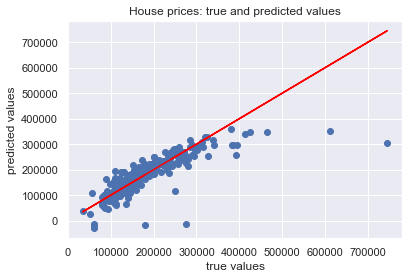

Mean absolute error of the prediction is: 26545.16057359938
Mean squared error of the prediction is: 2292633237.9876366
Root mean squared error of the prediction is: 47881.44983172123
Mean absolute percentage error of the prediction is: 15.584811305356993


In [82]:
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true and predicted values")
plt.show()


print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Although the R-squared value has improved by a few percentage points, the MAE, MSE, and RMSE metrics have gotten worse for this adjusted model- it seems like the errors are larger.  Visual inspection of the scatter plot suggests that this model is worse at dealing with outliers than the previous model.